## Imports

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
import seaborn as sns
from random import random, seed
from IPython.display import clear_output
import dataframe_image as dfi

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression, Ridge, Lasso

## The Franke function

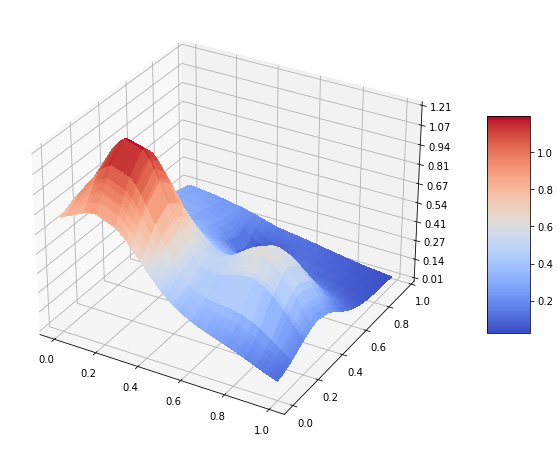

In [2]:
np.random.seed(12)

fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')

# Make data.
x = np.sort(np.random.uniform(0,1,50))
y = np.sort(np.random.uniform(0,1,50))
x, y = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4



z = FrankeFunction(x, y)


# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


# Customize the z axis.
# ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("Figures/Franke.png")
plt.show()

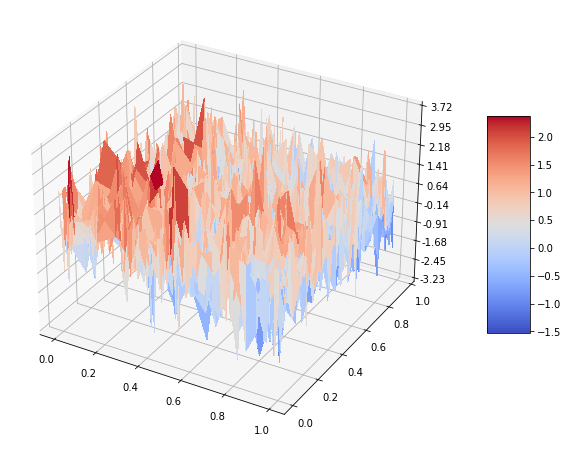

In [3]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')

z2 = FrankeFunction(x, y) + np.random.normal(0,1,(len(x),len(y)))

surf = ax.plot_surface(x, y, z2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
# ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("Figures/FrankeNoise.png")
plt.show()

## Function used in this project

In [4]:
def create_X(x, y, n ):
        if len(x.shape) > 1:
                x = np.ravel(x)
                y = np.ravel(y)

        N = len(x)
        l = int((n+1)*(n+2)/2)                                                                        
        X = np.ones((N,l))

        for i in range(1,n+1):
                q = int((i)*(i+1)/2)
                for k in range(i+1):
                        X[:,q+k] = (x**(i-k))*(y**k)
#                         print("X^{}*Y^{}".format(i-k,k))

        return X

def MSE(y,ytilde):

    return sum((y-ytilde)**2) / len(y)

def R2(y,ytilde):
    first = sum((y-ytilde)**2)
    second = sum((y-np.mean(y))**2)
    
    return 1 - first / second
def Bias(y,ytilde):
    return sum((y_test - np.mean(ytilde))**2) / len(y)

def Variance(y,ytilde):
    return np.var(ytilde)

def KFoldSplit(X,n_folds):

    n_folds = n_folds
    lenoffolds = (len(X) / n_folds)
    folds = []
    for i in range(n_folds):
        if i == range(n_folds)[-1]:
            first_ix = int(lenoffolds)*i
            second_ix = int(lenoffolds)*(i+1) 
            if second_ix != len(X):
                second_ix += 1
            else:
                pass
        else:
            first_ix = int(lenoffolds)*i
            second_ix = int(lenoffolds)*(i+1) 
        test_ix = np.arange(first_ix,second_ix)
        train_ix = np.delete(np.arange(0,len(X)),np.arange(first_ix,second_ix))
        folds.append((train_ix,test_ix))
        
    return folds

## Part a): Ordinary Least Square (OLS) on the Franke function

### Create the data

In [5]:
np.random.seed(12)
x = np.random.uniform(0,1,10)
y = np.random.uniform(0,1,10)

x, y = np.meshgrid(x,y)

X = create_X(x,y,5)

z = FrankeFunction(x, y) + np.random.normal(0,1,(len(x),len(y)))
z = z.ravel()
print("X shape:{}\nz shape:{}".format(X.shape,z.shape))

X shape:(100, 21)
z shape:(100,)


In [6]:
np.random.seed(12)


for n in range(5):
    
    X = create_X(x,y,n+1)
    x_train, x_test, y_train, y_test = train_test_split(X, z, test_size=0.2)

    scaler = StandardScaler()
    scaler.fit(x_train)
    X_train = scaler.transform(x_train)
    X_test = scaler.transform(x_test)
    X_train[:,0] = 1
    X_test[:,0] = 1

    beta = np.linalg.inv(X_train.T @ X_train) @ (X_train.T @ y_train)
    ytilde =  X_test @ beta
    ytilde_train = X_train @ beta
    
    print("Polynomial order:{}".format(n+1))
    
    print("Confidence interval (95 %): {:.2f} to {:.2f}".format(beta.mean()-np.sqrt(beta.var())*2,beta.mean()+np.sqrt(beta.var())*2))

    print("Test: MSE:{:.5f}   | Scikit-Learn MSE:{:.5f}".format(MSE(y_test,ytilde),mean_squared_error(y_test,ytilde)))
    print("Train: MSE:{:.5f}  | Scikit-Learn MSE:{:.5f}".format(MSE(y_train,ytilde_train),mean_squared_error(y_train,ytilde_train)))
    print(" ")
    print("Test: R2:{:.5f}    | Scikit-Learn R2:{:.5f}".format(R2(y_test,ytilde),r2_score(y_test,ytilde)))
    print("Train: R2:{:.5f}   | Scikit-Learn R2:{:.5f}".format(R2(y_train,ytilde_train),r2_score(y_train,ytilde_train)))
    print("-------------------------------------------")

Polynomial order:1
Confidence interval (95 %): -0.53 to 0.41
Test: MSE:1.18980   | Scikit-Learn MSE:1.18980
Train: MSE:1.08741  | Scikit-Learn MSE:1.08741
 
Test: R2:0.20808    | Scikit-Learn R2:0.20808
Train: R2:0.08665   | Scikit-Learn R2:0.08665
-------------------------------------------
Polynomial order:2
Confidence interval (95 %): -1.42 to 1.30
Test: MSE:1.03340   | Scikit-Learn MSE:1.03340
Train: MSE:1.07975  | Scikit-Learn MSE:1.07975
 
Test: R2:-0.03450    | Scikit-Learn R2:-0.03450
Train: R2:0.17792   | Scikit-Learn R2:0.17792
-------------------------------------------
Polynomial order:3
Confidence interval (95 %): -4.20 to 4.17
Test: MSE:0.84618   | Scikit-Learn MSE:0.84618
Train: MSE:1.05292  | Scikit-Learn MSE:1.05292
 
Test: R2:0.28093    | Scikit-Learn R2:0.28093
Train: R2:0.17333   | Scikit-Learn R2:0.17333
-------------------------------------------
Polynomial order:4
Confidence interval (95 %): -14.85 to 14.87
Test: MSE:1.93624   | Scikit-Learn MSE:1.93624
Train: MS

## Part b): Bias-variance trade-off and resampling techniques

In [7]:
np.random.seed(12)
x = np.random.uniform(0,1,10)
y = np.random.uniform(0,1,10)

x, y = np.meshgrid(x,y)

X = create_X(x,y,5)

z = FrankeFunction(x, y) + np.random.normal(0,1,(len(x),len(y)))
z = z.ravel()
print("X shape:{}\nz shape:{}".format(X.shape,z.shape))

X shape:(100, 21)
z shape:(100,)


In [8]:

mse_test = np.zeros((100,len(X.T)))
mse_train = np.zeros((100,len(X.T)))

for j in range(100):
    for i in range(len(X.T)):
        X_ = X[:,:i+1]
        x_train, x_test, y_train, y_test = train_test_split(X_, z, test_size=0.2)
        
        scaler = StandardScaler()
        scaler.fit(x_train)
        X_train = scaler.transform(x_train)
        X_test = scaler.transform(x_test)
        X_train[:,0] = 1
        X_test[:,0] = 1
        
        beta = np.linalg.inv(X_train.T @ X_train) @ (X_train.T @ y_train)
        ytilde =  X_test @ beta
        ytilde_train = X_train @ beta

        mse_test[j,i] = MSE(y_test,ytilde)
        mse_train[j,i] = MSE(y_train,ytilde_train)

df = pd.DataFrame(mse_test).rename_axis("Complexity",axis=1).rename_axis("Trials",axis=0).reset_index().melt(id_vars="Trials")
df2 = pd.DataFrame(mse_train).rename_axis("Complexity",axis=1).rename_axis("Trials",axis=0).reset_index().melt(id_vars="Trials")

In [9]:
df.value = np.log10(df.value)
df2.value = np.log10(df2.value)

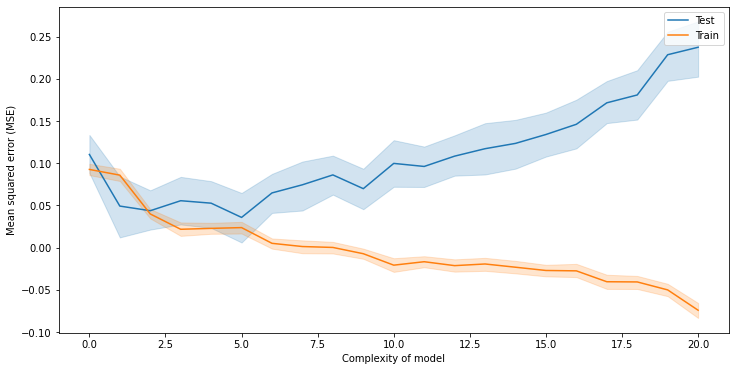

In [10]:


plt.figure(figsize=(12,6))
sns.lineplot(data=(df),x="Complexity",y ="value",label="Test")
sns.lineplot(data=(df2),x="Complexity",y ="value",label="Train")
plt.ylabel("Mean squared error (MSE)")
plt.xlabel("Complexity of model")
plt.legend()
plt.savefig("Figures/Partb1.png")
plt.show()

In [11]:
np.random.seed(12)
x = np.random.uniform(0,1,10)
y = np.random.uniform(0,1,10)
x, y = np.meshgrid(x,y)
X = create_X(x,y,5)

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X[:,0] = 1

z = FrankeFunction(x, y) + np.random.normal(0,1,(len(x),len(y)))
z = z.ravel()

In [12]:
np.random.seed(12)

N_datapoints = [7,8,9,10,11,12]
results_list = []

for N in N_datapoints:
    
    x = np.random.uniform(0,1,N)
    y = np.random.uniform(0,1,N)
    x_mesh, y_mesh = np.meshgrid(x,y)
    X = create_X(x_mesh,y_mesh,5)

    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    X[:,0] = 1

    z = FrankeFunction(x_mesh, y_mesh) + np.random.normal(0,1,(len(x),len(y)))
    z = z.ravel()
    X_train,X_test, y_train,y_test = train_test_split(X,z,test_size=0.2)

    y_test = y_test.reshape(-1,1)
    n_bootstraps = 100

    results_ols = np.zeros((len(X.T),3))

    for i in range(len(X.T)):

        Predictions_ols = np.zeros((len(X_test),n_bootstraps))

        for j in range(n_bootstraps):
            x_train_rs, y_train_rs = resample(X_train[:,:i+1],y_train)

            beta = np.linalg.inv(x_train_rs.T @ x_train_rs) @ (x_train_rs.T @ y_train_rs)
            ytilde_ols =  X_test[:,:i+1] @ beta

            Predictions_ols[:,j] = ytilde_ols

        mse = np.mean(np.mean((y_test - Predictions_ols)**2,axis=1, keepdims=True))
        bias = np.mean((y_test - np.mean(Predictions_ols,axis=1,keepdims=True))**2)
        variance = np.mean(np.var(Predictions_ols,axis=1,keepdims=True))
        results_ols[i] = np.array([mse,bias,variance])
    results_list.append(results_ols)

ols_bootstrap_results = pd.concat([pd.DataFrame(i,columns=["MSE","Bias","Variance"]) for i in results_list],axis=1, keys=[x**2 for x in N_datapoints])
ols_bootstrap_results = ols_bootstrap_results.rename_axis("Complexity",axis=0)
ols_bootstrap_results.columns.rename("N datapoints",0,inplace=True)
ols_bootstrap_results.index = ols_bootstrap_results.index +1 

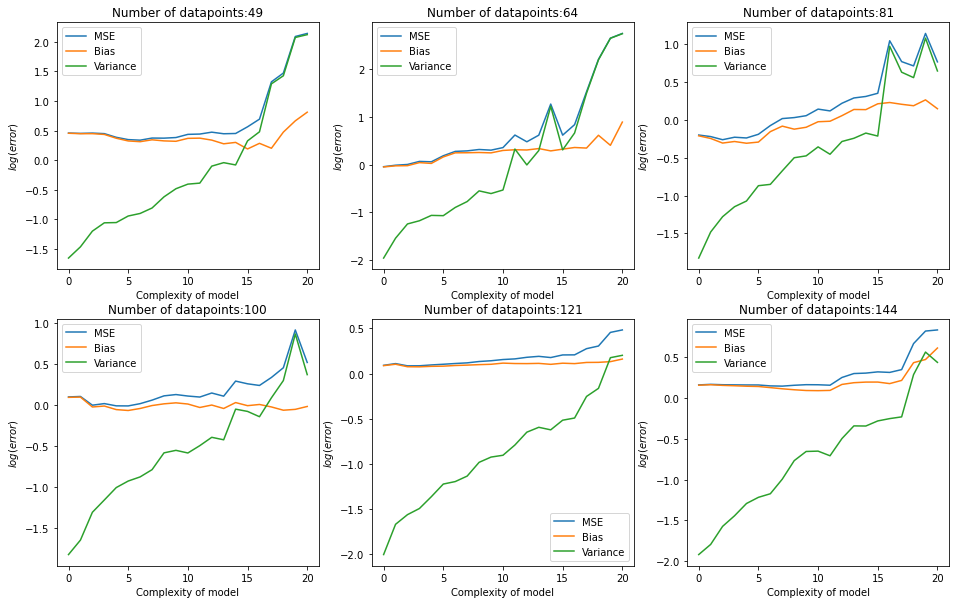

In [13]:
fig, ax = plt.subplots(2,3,figsize=(16,10))
i,j,k = 0,0,0
for results in results_list:
    
    df = pd.DataFrame(results,columns=["MSE","Bias","Variance"])
    df.apply(lambda x:np.log10(x)).plot(ax=ax[j,i],title ="Number of datapoints:{}".format(N_datapoints[k]**2))
    ax[j,i].set_xlabel("Complexity of model")
    ax[j,i].set_ylabel("$log(error)$")
    k += 1
    i += 1 
    if i ==3:
        j +=1
        i = 0
plt.savefig("Figures/Partb2.png")
plt.show()

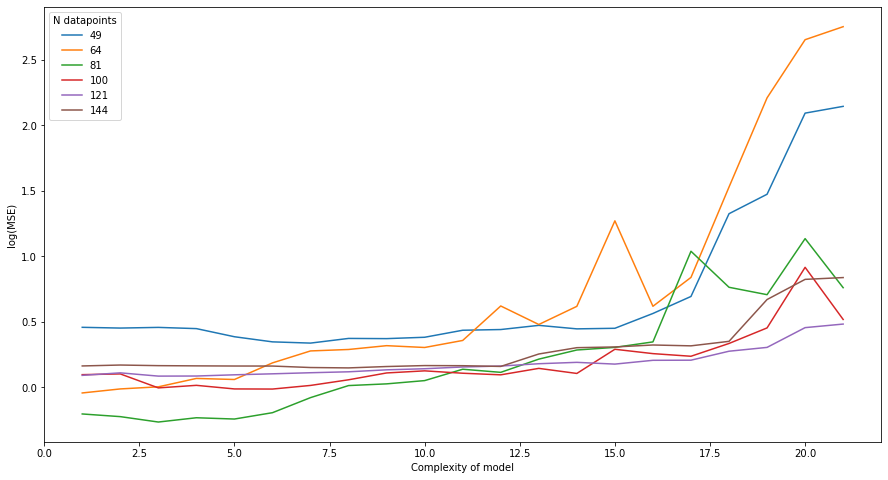

In [14]:
ols_bootstrap_results.loc[:,pd.IndexSlice[:,"MSE"]].droplevel(1,axis=1).apply(lambda x: np.log10(x)).plot(figsize=(15,8))
plt.xlabel("Complexity of model")
plt.ylabel("log(MSE)")
plt.savefig("Figures/Partb3.png")
plt.show()

## Part c) Cross-validation as resampling techniques, adding more complexity

In [15]:
np.random.seed(12)
x = np.random.uniform(0,1,10)
y = np.random.uniform(0,1,10)

x, y = np.meshgrid(x,y)
X = create_X(x,y,5)

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X[:,0] = 1

z = FrankeFunction(x, y) + np.random.normal(0,1,(len(x),len(y)))
z = z.ravel()

In [16]:
mse_list = []   
for n_folds in np.arange(5,11):

    mse = np.zeros(n_folds)
    i = 0

    for fold in KFoldSplit(X,n_folds):
        X_train,X_test,y_train,y_test = X[fold[0]],X[fold[1]],z[fold[0]],z[fold[1]]

        beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
        ytilde = X_test @ beta
        mse[i] = MSE(y_test,ytilde)
        i += 1 
    
    OLS = LinearRegression()
    estimated_mse_folds = cross_val_score(OLS, X, z, scoring='neg_mean_squared_error', cv=KFold(n_folds))
    
    mse_list.append((mse.mean(),abs(estimated_mse_folds).mean()))
ols_CV_results = pd.DataFrame(mse_list,index=np.arange(5,11),columns=["MSE","Scikit-learn MSE"]).rename_axis("Number of folds")

In [17]:
dfi.export(ols_CV_results,"Figures/ols_CV_Results.png",fontsize=16)
ols_CV_results

,MSE,Scikit-learn MSE
Number of folds,,
5,25.418494,25.418494
6,1.805152,10.518405
7,4.441928,4.573210
8,2.212151,9.337058
9,4.374121,4.454320
10,10.793917,10.793917


In [18]:
dfi.export(ols_bootstrap_results.loc[[21],100],"Figures/ols_bootstrap_Results.png")
ols_bootstrap_results.loc[[21],100]

,MSE,Bias,Variance
Complexity,,,
21,3.295277,0.955321,2.339956


## Part d): Ridge Regression on the Franke function with resampling

### Ridge regression with bootstrap

In [19]:
np.random.seed(12)
x = np.random.uniform(0,1,10)
y = np.random.uniform(0,1,10)
x, y = np.meshgrid(x,y)
X = create_X(x,y,5)

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X[:,0] = 1

z = FrankeFunction(x, y) + np.random.normal(0,1,(len(x),len(y)))
z = z.ravel()

In [20]:
np.random.seed(12)
n_bootstraps = 100
X_train,X_test, y_train,y_test = train_test_split(X,z,test_size=0.2)
I = np.eye(len(X.T),len(X.T))
lambdas = np.logspace(-2,0.5,10)
results_list = []

for i in range(len(X.T)):
    
    lmb_results = np.zeros((10,3))
    for j in range(10):
        np.random.seed(12)
        lmb = lambdas[j]
        
        Predictions_ridge = np.zeros((len(X_test),n_bootstraps))
        
        for k in range(n_bootstraps):
            x_train_rs, y_train_rs = resample(X_train[:,:i+1],y_train)
            beta = np.linalg.inv(x_train_rs.T@x_train_rs +lmb*I[:i+1,:i+1]) @ x_train_rs.T@y_train_rs
            ytilde_ridge =  X_test[:,:i+1] @ beta
            Predictions_ridge[:,j] = ytilde_ridge
        y_test = y_test.reshape(-1,1)
       
        mse = np.mean(np.mean((y_test - Predictions_ridge)**2,axis=1, keepdims=True))
        bias = np.mean((y_test - np.mean(Predictions_ridge,axis=1,keepdims=True))**2)
        variance = np.mean(np.var(Predictions_ridge,axis=1,keepdims=True))
        lmb_results[j,:] = np.array([mse,bias,variance])
        print("Lambdas: {}/{}".format(j+1,len(lambdas)))
        print("Complexity: {}/{}".format(i+1,len(X.T)))
        clear_output(wait=True)

    results_list.append(lmb_results)

ridge_bootstrap_results = pd.concat([pd.DataFrame(i,columns=["MSE","Bias","Variance"]).T for i in results_list],axis=0, keys=[x for x in np.arange(1,22)])
ridge_bootstrap_results.columns = [np.log10(x) for x in lambdas]
ridge_bootstrap_results = ridge_bootstrap_results.unstack(1)
formatColumns = ridge_bootstrap_results.columns.levels[0].map("{:.2f}".format).to_list()
col2 = ["MSE","Bias","Variance"]
ridge_bootstrap_results.columns = pd.MultiIndex.from_product([formatColumns,col2])

Lambdas: 10/10
Complexity: 21/21


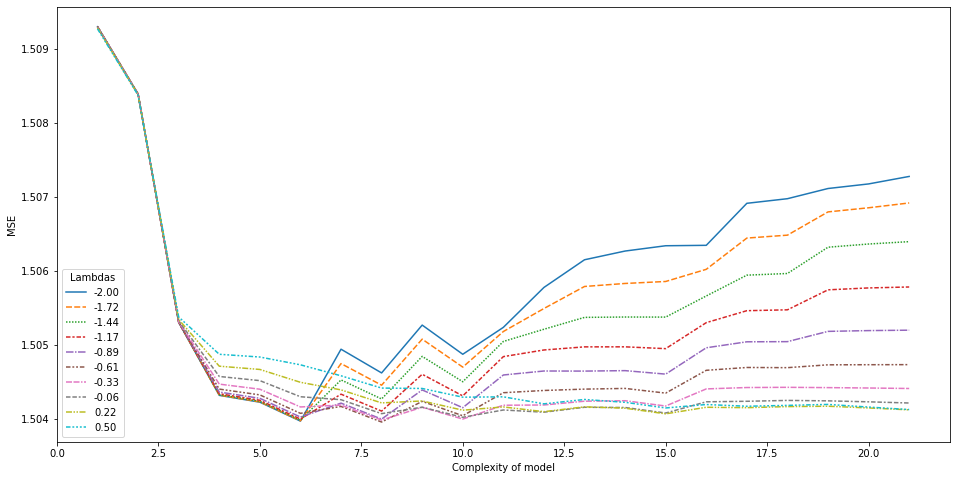

In [21]:
plt.figure(figsize=(16,8))
sns.lineplot(data=ridge_bootstrap_results.loc[:,pd.IndexSlice[:,"MSE"]])
plt.legend(title="Lambdas")
plt.xlabel("Complexity of model")
plt.ylabel("MSE")
plt.savefig("Figures/Partd1.png")

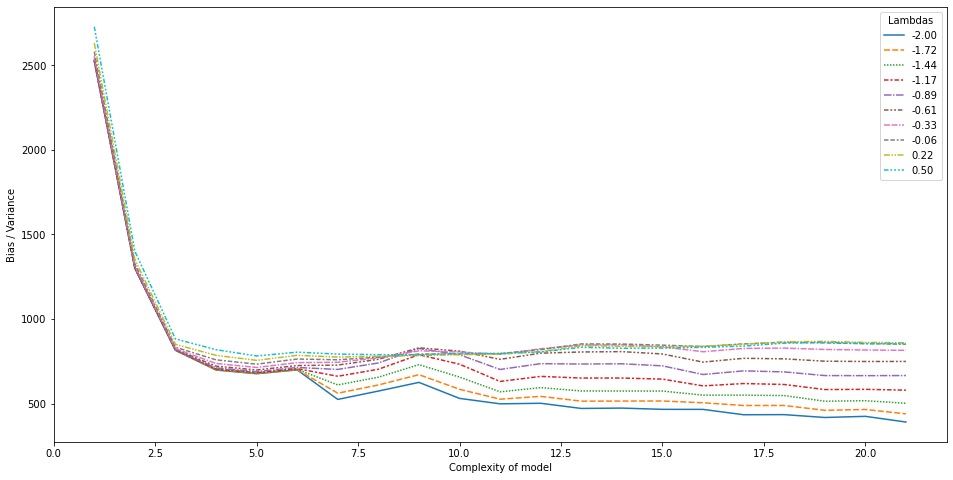

In [22]:
BiasVarianceRatio = (ridge_bootstrap_results.loc[:,pd.IndexSlice[:,"Bias"]].values /ridge_bootstrap_results.loc[:,pd.IndexSlice[:,"Variance"]]).droplevel(1,axis=1)
plt.figure(figsize=(16,8))
sns.lineplot(data=BiasVarianceRatio)
plt.xlabel("Complexity of model")
plt.ylabel("Bias / Variance")
plt.legend(title="Lambdas")
plt.savefig("Figures/Partd2.png")
plt.show()

### Ridge Regression with cross-validation

In [23]:
np.random.seed(12)
x = np.random.uniform(0,1,10)
y = np.random.uniform(0,1,10)
x, y = np.meshgrid(x,y)
X = create_X(x,y,5)

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X[:,0] = 1

z = FrankeFunction(x, y) + np.random.normal(0,1,(len(x),len(y)))
z = z.ravel()

In [24]:
# n_folds = 10 



I = np.eye(len(X.T),len(X.T))

lambdas = np.logspace(-2,0.5,10)
results_list = []

for lmb in lambdas: 
    mse_list = [] 
    for n_folds in np.arange(5,11):

        mse = np.zeros(n_folds)
        i = 0

#         print("Number of folds:{}".format(n_folds))
        for fold in KFoldSplit(X,n_folds):

            X_train,X_test,y_train,y_test = X[fold[0]],X[fold[1]],z[fold[0]],z[fold[1]]

            beta = np.linalg.inv(X_train.T@X_train +lmb*I) @ X_train.T@y_train
            ytilde = X_test @ beta


            mse[i] = MSE(y_test,ytilde)
            i += 1 

        ridge = Ridge(alpha=lmb)
        estimated_mse_folds = cross_val_score(ridge, X, z, scoring='neg_mean_squared_error', cv=KFold(n_folds))

        mse_list.append((mse.mean(),abs(estimated_mse_folds).mean()))
    
#         print("Cross-Validation MSE:{:.4f}\nScikit-Learn CV MSE:{:.4f}".format(mse.mean(),abs(estimated_mse_folds).mean()))
#         print("---------------------------")
    results_list.append(mse_list)
ridge_CV_results = pd.concat([pd.DataFrame(df,columns=["MSE","Scikit-learn MSE"],index=np.arange(5,11)) for df in results_list],axis=1,keys=[np.log10(x) for x in lambdas])
formatColumns = ridge_CV_results.columns.levels[0].map("{:.2f}".format).to_list()
col2 = ["MSE","Scikit-learn MSE"]
ridge_CV_results.columns = pd.MultiIndex.from_product([formatColumns,col2])
ridge_CV_results = ridge_CV_results.rename_axis("Number of folds",axis=0)

In [25]:
ridge_CV_results

-2.00                      -1.72                   \
                      MSE Scikit-learn MSE       MSE Scikit-learn MSE   
Number of folds                                                         
5                2.404038         2.406950  2.013105         2.016047   
6                1.756353         2.096981  1.662436         1.966490   
7                1.888509         2.231228  1.782914         2.062139   
8                1.539570         1.466599  1.466804         1.419336   
9                1.907363         1.918090  1.783053         1.792506   
10               1.969920         1.970182  1.849182         1.849597   

                    -1.44                      -1.17                   \
                      MSE Scikit-learn MSE       MSE Scikit-learn MSE   
Number of folds                                                         
5                1.762553         1.765632  1.577712         1.580845   
6                1.576967         1.851642  1.495504         1.740565   
7                1.691011         1.913656  1.601942         1.770786   
8                1.412003         1.391836  1.370261         1.367890   
9                1.681527         1.687855  1.588767         1.590481   
10               1.756732         1.757375  1.669264         1.670237   

                    -0.89                      -0.61                   \
                      MSE Scikit-learn MSE       MSE Scikit-learn MSE   
Number of folds                                                         
5                1.438145         1.440976  1.344996         1.346930   
6                1.417816         1.628734  1.348820         1.519975   
7                1.517313         1.633591  1.444219         1.512649   
8                1.338951         1.341851  1.317274         1.315035   
9                1.501928         1.498951  1.425679         1.419926   
10               1.577360         1.578792  1.485107         1.487129   

                    -0.33                      -0.06                   \
                      MSE Scikit-learn MSE       MSE Scikit-learn MSE   
Number of folds                                                         
5                1.297247         1.297652  1.284000         1.282429   
6                1.293899         1.422727  1.254323         1.344715   
7                1.386163         1.416449  1.340667         1.344562   
8                1.304090         1.290634  1.296518         1.270115   
9                1.364338         1.358513  1.317460         1.313449   
10               1.402247         1.404980  1.335534         1.339109   

                     0.22                       0.50                   
                      MSE Scikit-learn MSE       MSE Scikit-learn MSE  
Number of folds                                                        
5                1.288712         1.284909  1.298054         1.291811  
6                1.226682         1.287129  1.205832         1.244347  
7                1.302629         1.290258  1.268235         1.246447  
8                1.290456         1.252396  1.282653         1.235437  
9                1.280769         1.279252  1.249580         1.250586  
10               1.284833         1.289440  1.245342         1.251160

In [26]:
df = data=ridge_CV_results.loc[:,pd.IndexSlice[:,"MSE"]]
df

,-2.00,-1.72,-1.44,-1.17,-0.89,-0.61,-0.33,-0.06,0.22,0.50
,MSE,MSE,MSE,MSE,MSE,MSE,MSE,MSE,MSE,MSE
Number of folds,,,,,,,,,,
5,2.404038,2.013105,1.762553,1.577712,1.438145,1.344996,1.297247,1.284000,1.288712,1.298054
6,1.756353,1.662436,1.576967,1.495504,1.417816,1.348820,1.293899,1.254323,1.226682,1.205832
7,1.888509,1.782914,1.691011,1.601942,1.517313,1.444219,1.386163,1.340667,1.302629,1.268235
8,1.539570,1.466804,1.412003,1.370261,1.338951,1.317274,1.304090,1.296518,1.290456,1.282653
9,1.907363,1.783053,1.681527,1.588767,1.501928,1.425679,1.364338,1.317460,1.280769,1.249580
10,1.969920,1.849182,1.756732,1.669264,1.577360,1.485107,1.402247,1.335534,1.284833,1.245342


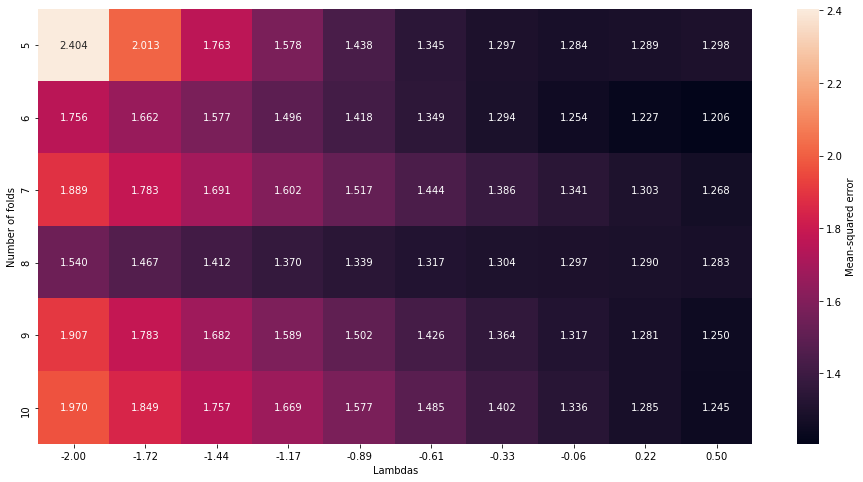

In [27]:
plt.figure(figsize=(16,8))
sns.heatmap(data=ridge_CV_results.loc[:,pd.IndexSlice[:,"MSE"]].droplevel(1,1),annot=True,fmt=".3f", cbar_kws={'label': 'Mean-squared error'})
plt.xlabel("Lambdas")
plt.savefig("Figures/Partd3.png")

## Part e): Lasso Regression on the Franke function with resampling

### Lasso Regression with bootstrap

In [28]:
np.random.seed(12)
x = np.random.uniform(0,1,10)
y = np.random.uniform(0,1,10)
x, y = np.meshgrid(x,y)
X = create_X(x,y,5)

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X[:,0] = 1

z = FrankeFunction(x, y) + np.random.normal(0,1,(len(x),len(y)))
z = z.ravel()

In [29]:
np.random.seed(12)
n_bootstraps = 100

X_train,X_test, y_train,y_test = train_test_split(X,z,test_size=0.2)

# I = np.eye(len(X.T),len(X.T))
lambdas = np.logspace(-2,0.5,10)
results_list = []

for i in range(len(X.T)):
    
    lmb_results = np.zeros((len(lambdas),3))
    for j in range(len(lambdas)):
        np.random.seed(12)
        lmb = lambdas[j]
        
        Predictions_lasso = np.zeros((len(X_test),n_bootstraps))
        
        for k in range(n_bootstraps):
            x_train_rs, y_train_rs = resample(X_train[:,:i+1],y_train)
            
            lasso = Lasso(alpha=lmb,max_iter=10000)
            ytilde_lasso = lasso.fit(x_train_rs,y_train_rs).predict(X_test[:,:i+1])
            
            
            Predictions_lasso[:,j] = ytilde_lasso
        y_test = y_test.reshape(-1,1)
       
        mse = np.mean(np.mean((y_test - Predictions_lasso)**2,axis=1, keepdims=True))
        bias = np.mean((y_test - np.mean(Predictions_lasso,axis=1,keepdims=True))**2)
        variance = np.mean(np.var(Predictions_lasso,axis=1,keepdims=True))
        lmb_results[j,:] = np.array([mse,bias,variance])
        print("Lambdas: {}/{}".format(j+1,len(lambdas)))
        print("Complexity: {}/{}".format(i+1,len(X.T)))
        clear_output(wait=True)
        
    results_list.append(lmb_results)

lasso_bootstrap_results = pd.concat([pd.DataFrame(i,columns=["MSE","Bias","Variance"]).T for i in results_list],axis=0, keys=[x for x in np.arange(1,22)])
lasso_bootstrap_results.columns = [np.log10(x) for x in lambdas]
lasso_bootstrap_results = lasso_bootstrap_results.unstack(1)
formatColumns = lasso_bootstrap_results.columns.levels[0].map("{:.2f}".format).to_list()
col2 = ["MSE","Bias","Variance"]
lasso_bootstrap_results.columns = pd.MultiIndex.from_product([formatColumns,col2])

Lambdas: 10/10
Complexity: 21/21


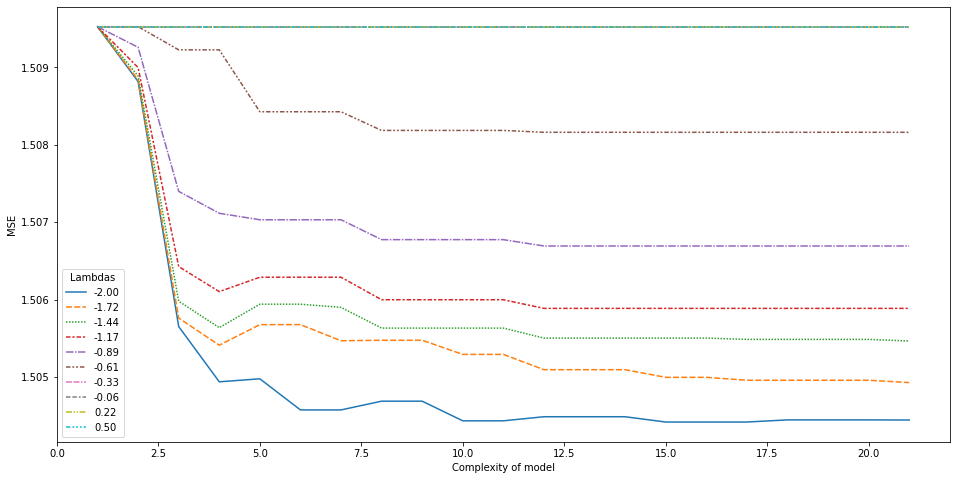

In [30]:
plt.figure(figsize=(16,8))
plt.ylabel("MSE")
plt.xlabel("Complexity of model")
sns.lineplot(data=lasso_bootstrap_results.loc[:,pd.IndexSlice[:,"MSE"]])
plt.legend(title="Lambdas")
plt.savefig("Figures/Parte1.png")

<AxesSubplot:>

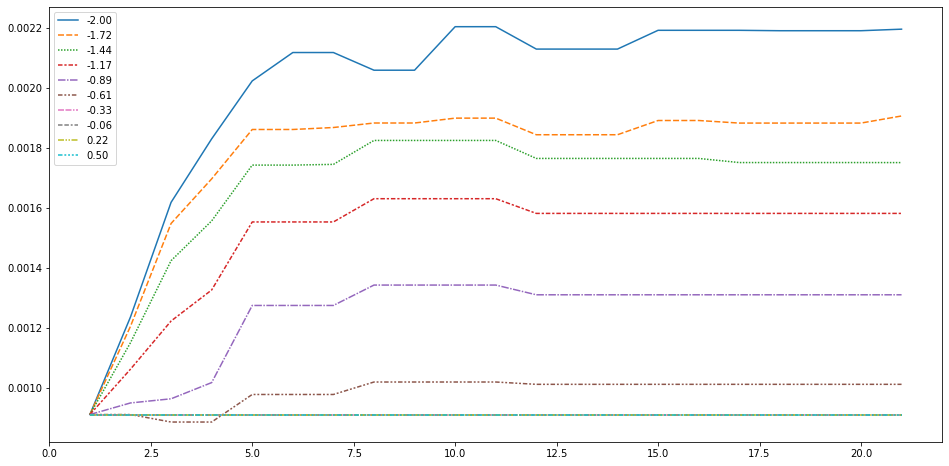

In [31]:
plt.figure(figsize=(16,8))
sns.lineplot(data=lasso_bootstrap_results.loc[:,pd.IndexSlice[:,"Variance"]])

<AxesSubplot:>

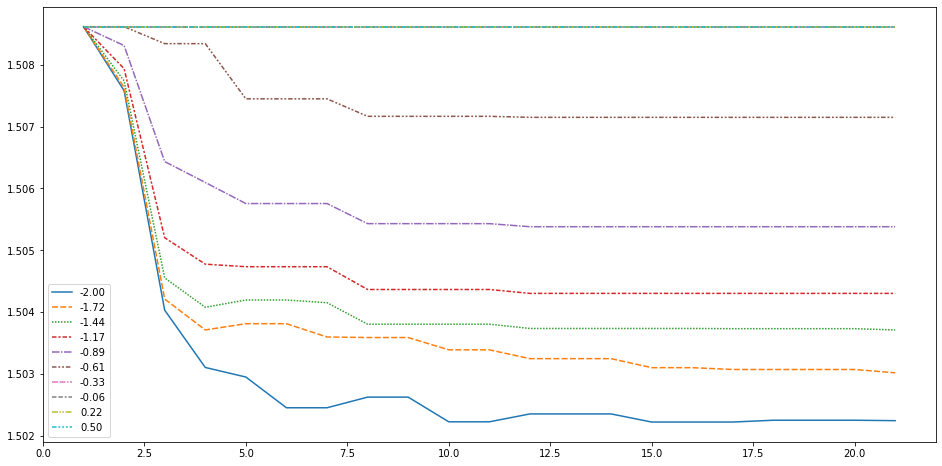

In [32]:
plt.figure(figsize=(16,8))
sns.lineplot(data=lasso_bootstrap_results.loc[:,pd.IndexSlice[:,"Bias"]])

<AxesSubplot:>

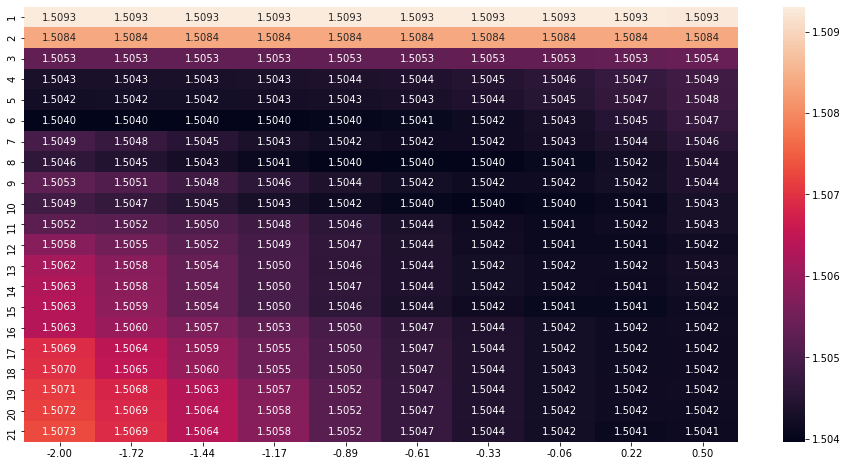

In [33]:
plt.figure(figsize=(16,8))
sns.heatmap(ridge_bootstrap_results.loc[:,pd.IndexSlice[:,"MSE"]].droplevel(1,1),annot=True,fmt=".4f")

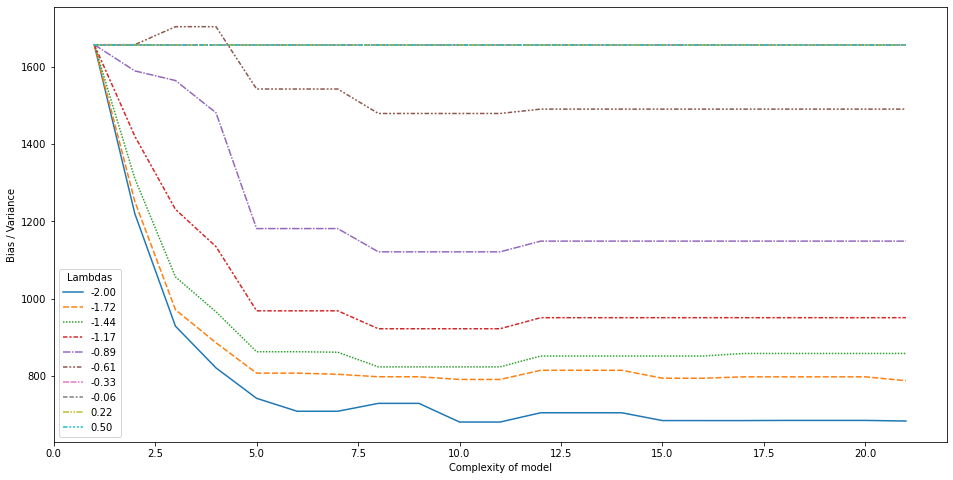

In [34]:
BiasVarianceRatio = (lasso_bootstrap_results.loc[:,pd.IndexSlice[:,"Bias"]].values /lasso_bootstrap_results.loc[:,pd.IndexSlice[:,"Variance"]]).droplevel(1,axis=1)
plt.figure(figsize=(16,8))
sns.lineplot(data=BiasVarianceRatio)
plt.xlabel("Complexity of model")
plt.ylabel("Bias / Variance")
plt.legend(title="Lambdas")
plt.savefig("Figures/Parte2.png")
plt.show()

<AxesSubplot:>

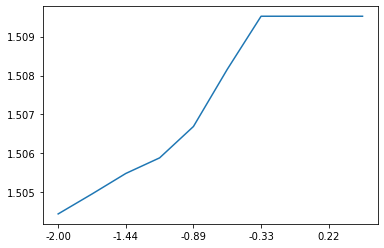

In [35]:
lasso_bootstrap_results.loc[20,pd.IndexSlice[:,"MSE"]].droplevel(1).plot()

### Lasso regression with cross-validation

In [36]:
np.random.seed(12)
x = np.random.uniform(0,1,10)
y = np.random.uniform(0,1,10)
x, y = np.meshgrid(x,y)
X = create_X(x,y,5)

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X[:,0] = 1

z = FrankeFunction(x, y) + np.random.normal(0,1,(len(x),len(y)))
z = z.ravel()

In [37]:
lambdas = np.logspace(-2,0.5,10)
results_list = []

for lmb in lambdas: 
    mse_list = [] 
    for n_folds in np.arange(5,11):

        mse = np.zeros(n_folds)
        i = 0

#         print("Number of folds:{}".format(n_folds))
        for fold in KFoldSplit(X,n_folds):

            X_train,X_test,y_train,y_test = X[fold[0]],X[fold[1]],z[fold[0]],z[fold[1]]
            
            lasso = Lasso(alpha=lmb, max_iter=30000)
            ytilde = lasso.fit(X_train,y_train).predict(X_test)


            mse[i] = MSE(y_test,ytilde)
            i += 1 

#         lasso = Ridge(alpha=lmb)
        estimated_mse_folds = cross_val_score(lasso, X, z, scoring='neg_mean_squared_error', cv=KFold(n_folds))

        mse_list.append((mse.mean(),abs(estimated_mse_folds).mean()))
    
#         print("Cross-Validation MSE:{:.4f}\nScikit-Learn CV MSE:{:.4f}".format(mse.mean(),abs(estimated_mse_folds).mean()))
#         print("---------------------------")
    results_list.append(mse_list)
lasso_CV_results = pd.concat([pd.DataFrame(df,columns=["MSE","Scikit-learn MSE"],index=np.arange(5,11)) for df in results_list],axis=1,keys=[np.log10(x) for x in lambdas])
lasso_CV_results = lasso_CV_results.rename_axis("N folds",axis=0)
formatColumns = lasso_CV_results.columns.levels[0].map("{:.2f}".format).to_list()
col2 = ["MSE","Scikit-learn MSE"]
lasso_CV_results.columns = pd.MultiIndex.from_product([formatColumns,col2])

In [38]:
lasso_CV_results

-2.00                      -1.72                      -1.44  \
              MSE Scikit-learn MSE       MSE Scikit-learn MSE       MSE   
N folds                                                                   
5        1.343545         1.343545  1.294858         1.294858  1.231743   
6        1.221012         1.286678  1.186205         1.200710  1.172667   
7        1.271580         1.269462  1.216973         1.186438  1.193224   
8        1.282826         1.234626  1.268633         1.215845  1.236337   
9        1.257805         1.256907  1.201058         1.211466  1.182282   
10       1.293896         1.293896  1.210570         1.210570  1.178216   

                             -1.17                      -0.89  \
        Scikit-learn MSE       MSE Scikit-learn MSE       MSE   
N folds                                                         
5               1.231743  1.179455         1.179455  1.168849   
6               1.172737  1.154173         1.155144  1.160483   
7               1.161310  1.179917         1.151398  1.190760   
8               1.196591  1.210408         1.180996  1.212119   
9               1.193037  1.168069         1.177400  1.171482   
10              1.178216  1.171836         1.171836  1.177428   

                             -0.61                      -0.33  \
        Scikit-learn MSE       MSE Scikit-learn MSE       MSE   
N folds                                                         
5               1.168849  1.208385         1.208385  1.273355   
6               1.159162  1.225899         1.219529  1.301197   
7               1.155442  1.251123         1.224131  1.310816   
8               1.181520  1.272105         1.252369  1.319421   
9               1.181436  1.235503         1.248715  1.307265   
10              1.177428  1.250751         1.250751  1.309597   

                             -0.06                       0.22  \
        Scikit-learn MSE       MSE Scikit-learn MSE       MSE   
N folds                                                         
5               1.273355  1.273355         1.273355  1.273355   
6               1.279561  1.301197         1.279561  1.301197   
7               1.289536  1.310816         1.289536  1.310816   
8               1.321630  1.319421         1.321630  1.319421   
9               1.317794  1.307265         1.317794  1.307265   
10              1.309597  1.309597         1.309597  1.309597   

                              0.50                   
        Scikit-learn MSE       MSE Scikit-learn MSE  
N folds                                              
5               1.273355  1.273355         1.273355  
6               1.279561  1.301197         1.279561  
7               1.289536  1.310816         1.289536  
8               1.321630  1.319421         1.321630  
9               1.317794  1.307265         1.317794  
10              1.309597  1.309597         1.309597

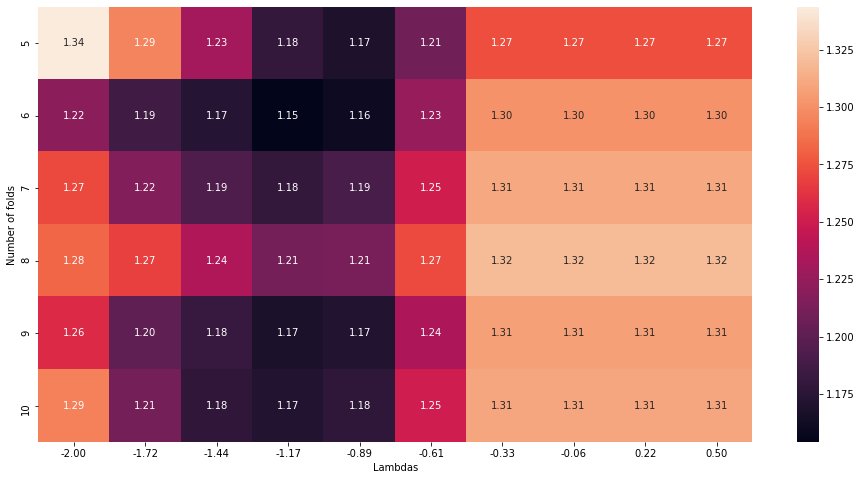

In [39]:
plt.figure(figsize=(16,8))
sns.heatmap(lasso_CV_results.loc[:,pd.IndexSlice[:,"MSE"]].droplevel(1,1),annot=True,fmt=".2f")
plt.xlabel("Lambdas")
plt.ylabel("Number of folds")
plt.savefig("Figures/Parte3.png")

## Part f): Introducing real data and preparing the data analysis

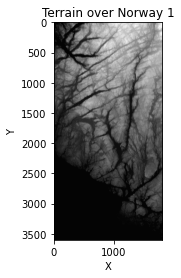

In [40]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Load the terrain
terrain1 = imread('SRTM_data_Norway_2.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig("Figures/Terrainfull.png")
plt.show()

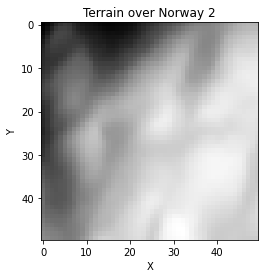

In [41]:
# Load the terrain                                                                                  
terrain = imread('SRTM_data_Norway_2.tif')

# just fixing a set of points
N = 50
m = 5 # polynomial order                                                                            
terrain = terrain[:N,-N:]
# Creates mesh of image pixels                                                                      
x = np.linspace(0,1, np.shape(terrain)[0])
y = np.linspace(0,1, np.shape(terrain)[1])
x, y = np.meshgrid(x,y)
# Note the use of meshgrid
X = create_X(x, y,m)
# you have to provide this function

# Show the terrain                                                                                  
plt.figure()
plt.title('Terrain over Norway 2')
plt.imshow(terrain, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [42]:
np.random.seed(12)

N = 20
terrain = terrain[:N,-N:]

x = np.linspace(0,1, np.shape(terrain)[0])
y = np.linspace(0,1, np.shape(terrain)[1])

x, y = np.meshgrid(x,y)
X = create_X(x, y,m)

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X[:,0] = 1

z = terrain.ravel()

In [43]:
terrain.shape

(20, 20)

In [44]:
x.shape

(20, 20)

In [45]:
z.shape

(400,)

In [46]:
lambdas = np.logspace(-2,0.5,10)
results_list = []

ols_results_list = []
ridge_results_list = [] 
lasso_results_list = []
k = 0
for lmb in lambdas: 
    mse_ols_list = []
    mse_ridge_list = []
    mse_lasso_list = []
    mse_list = []
    j = 0
    for n_folds in np.arange(5,11):

        mse_ols = np.zeros(n_folds)
        mse_ridge = np.zeros(n_folds)
        mse_lasso = np.zeros(n_folds)
        mse = np.zeros(n_folds)
        i = 0

        for fold in KFoldSplit(X,n_folds):

            X_train,X_test,y_train,y_test = X[fold[0]],X[fold[1]],z[fold[0]],z[fold[1]]
            
            ols = LinearRegression()
            ytilde_ols = ols.fit(X_train,y_train).predict(X_test)
            
            ridge = Ridge(alpha=lmb)
            ytilde_ridge = ridge.fit(X_train,y_train).predict(X_test)
            
            lasso = Lasso(alpha=lmb, max_iter=100000)
            ytilde_lasso = lasso.fit(X_train,y_train).predict(X_test)
            
            
            mse_ols[i] = MSE(y_test,ytilde_ols)
            mse_ridge[i] = MSE(y_test,ytilde_ridge)
            mse_lasso[i] = MSE(y_test,ytilde_lasso)
#             mse[i] = MSE(y_test,ytilde)
            i += 1 
            print("Fold:{}/{}".format(i,n_folds))
            print("N_fold:{}/{}".format(j+1,len(np.arange(5,11))))
            print("Lambdas:{}/{}".format(k+1,len(lambdas)))
            clear_output(wait=True)
#         lasso = Ridge(alpha=lmb)
    
        mse_ols_list.append(mse_ols.mean())
        mse_ridge_list.append(mse_ridge.mean())
        mse_lasso_list.append(mse_lasso.mean())
        mse_list.append((mse_ols.mean(),mse_ridge.mean(),mse_lasso.mean()))
        j += 1
#         print("Cross-Validation MSE:{:.4f}\nScikit-Learn CV MSE:{:.4f}".format(mse.mean(),abs(estimated_mse_folds).mean()))
#         print("---------------------------")
    ols_results_list.append(mse_ols_list)
    ridge_results_list.append(mse_ridge_list)
    lasso_results_list.append(mse_lasso_list)
    results_list.append(mse_list)
    k += 1
    
    
# lasso_CV_results = pd.concat([pd.DataFrame(df,columns=["MSE","Scikit-learn MSE"],index=np.arange(5,11)) for df in ols_results_list],axis=1,keys=[np.log10(x) for x in lambdas])
# lasso_CV_results = lasso_CV_results.rename_axis("N folds",axis=0)
# formatColumns = lasso_CV_results.columns.levels[0].map("{:.2f}".format).to_list()
# col2 = ["MSE","Scikit-learn MSE"]
# lasso_CV_results.columns = pd.MultiIndex.from_product([formatColumns,col2])


results = pd.concat([pd.DataFrame(df,columns=["OLS","Ridge","Lasso"],index=np.arange(5,11)) for df in results_list],axis=1,keys=[np.log10(x) for x in lambdas])
results = results.rename_axis("N folds",axis=0)
formatColumns = results.columns.levels[0].map("{:.2f}".format).to_list()
col2 = ["OLS","Ridge","Lasso"]
results.columns = pd.MultiIndex.from_product([formatColumns,col2])



Fold:10/10
N_fold:6/6
Lambdas:10/10


In [47]:
dfi.export(results.stack(0).unstack(0).round(1)[["Ridge","Lasso"]].style.background_gradient(),"Figures/RidgeLassoResult.png")
results.stack(0).unstack(0).round(1)[["Ridge","Lasso"]].style.background_gradient()

In [48]:
dfi.export(results.stack(0)[["OLS"]].droplevel(1).drop_duplicates(),"Figures/OLS Results.png")
results.stack(0)[["OLS"]].droplevel(1).drop_duplicates()

,OLS
N folds,
5,200.969800
6,177.621580
7,101.594888
8,75.400293
9,70.649340
10,48.033013


In [49]:
result_table = pd.DataFrame(results.min().sort_values()).drop_duplicates()
result_table = result_table.reset_index()
result_table.loc[0,"level_0"] = "-"
result_table = result_table.rename(columns={"level_0":"Lambda","level_1":"Method",0:"MSE"}).set_index(["Lambda","Method"])

dfi.export(result_table,"Figures/result_table2.png")
result_table

,,MSE
Lambda,Method,
-,OLS,48.033013
-2.00,Ridge,108.002575
-0.89,Ridge,111.307910
-0.61,Ridge,111.449049
-1.72,Ridge,112.574759
-1.17,Ridge,112.587732
-0.33,Ridge,113.472991
-1.44,Ridge,113.620977
-0.06,Ridge,117.225305
